In [1351]:
import json
import random

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from Levenshtein import distance

from utils import *

random.seed(1234567890)

In [1352]:
def map_to_intent(text, intents):
    distances = torch.tensor([distance(text, intent) for intent in intents])
    closest_match = intents[distances.argmin(dim=0)]
    return closest_match

In [ ]:
root_dir = ''
data_dir = ''
encoder = 'bge-large-en-v1.5'
# encoder = 'gte-large'
enc_setup = 'e+p+om'
# enc_setup = 'e'

top_k = 5

model_to_name = {
    'llama-3.1-8b-instruct': 'Meta-Llama-3.1-8B-Instruct',
    'gemma-2-9b-it': 'gemma-2-9b-it',
    'phi-3-medium-4k-instruct': 'Phi-3-medium-4k-instruct',
    'mistral-7b-instruct': 'Mistral-7B-Instruct-v0.3'
}

model_type = 'llama-3.1-8b-instruct'
model_type = 'gemma-2-9b-it'
# model_type = 'phi-3-medium-4k-instruct'
# model_type = 'mistral-7b-instruct'
model_name = model_to_name[model_type]

quantization = '4_bit_quant_k5'
quantization = '8_bit_quant_k5'
# quantization = 'full'

task = 'clinic150'

labels, _, texts, model_outs, intents = load_data(task, model_type, model_name, quantization)
# preds = torch.tensor([intents.index(map_to_intent(entry, intents)) for entry in model_outs])

all_candidates = json.load(open(f"{root_dir}/candidates/{task}-{encoder}-{enc_setup}-{top_k}-cands.jsonl"))
preds = torch.tensor([intents.index(map_to_intent(entry, candidates)) for (entry, candidates) in zip(model_outs, all_candidates)])

In [1354]:
score(labels, preds)  # Sanity check

 acc: 0.9080 macro-f1: 0.9045
90.8 90.45


(0.908, 0.9045334634564187)

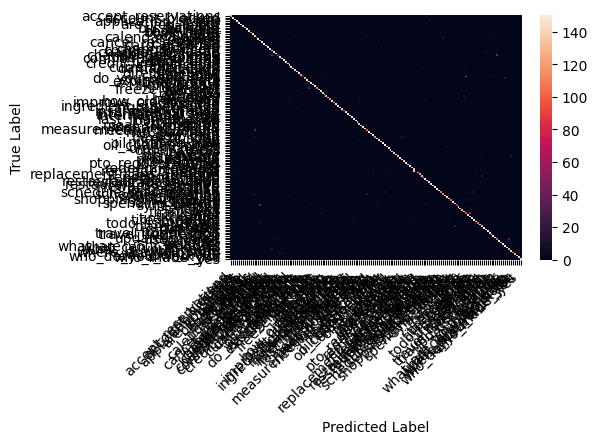

In [1355]:
cfm_and_plot(labels, preds, intents, annot=(task not in ['clinic150', 'massive']))

In [1356]:
data = json.load(open(f"{data_dir}/{task}/data-full-shuffled.json"))['data']
data = list(filter(lambda x: x['intent'] not in ['cheapest', 'day_name'], data))
ls = torch.tensor([intents.index(entry['intent']) for entry in data])

sims = torch.load(f"{root_dir}/sims/{task}-{encoder}-sims-{enc_setup}.pt", weights_only=True)
if task == 'atis':
    sims[:, [6, 8]] = -1
enc_preds = torch.argmax(sims, dim=1)

score(ls, enc_preds)

 acc: 0.8195 macro-f1: 0.8109
81.95 81.09


(0.8195111111111111, 0.8108640562671392)

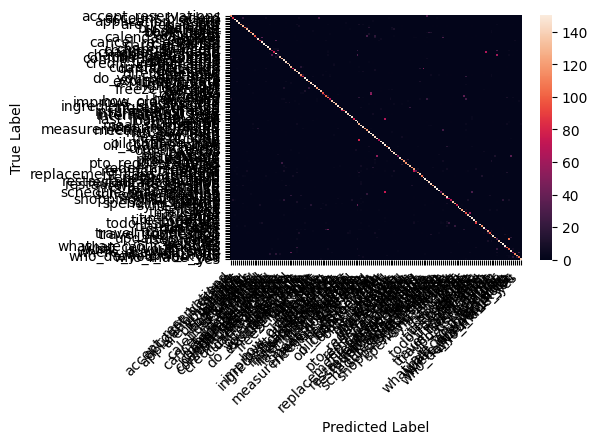

In [1357]:
cfm_and_plot(ls, enc_preds, intents, annot=(task not in ['clinic150', 'massive']))

/tmp/ipykernel_1327399/572185070.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  desc_embeds = torch.load(f"/home/roy/workspace/semantic-sim-intent/output/{task}-bge-lar

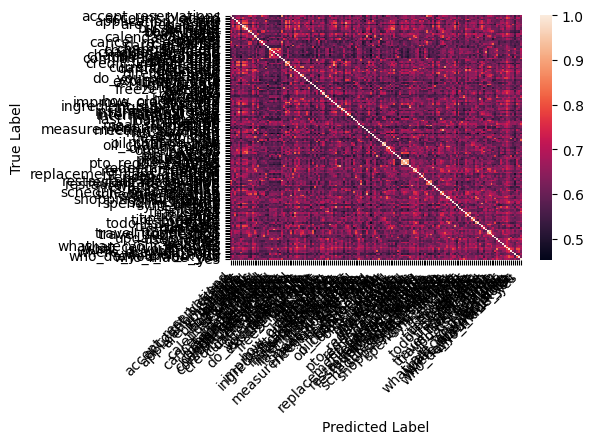

In [ ]:
desc_embeds = torch.load(f"{task}-bge-large-en-v1.5-descriptions-desc-embeds.pt")
desc_sims = normalise(desc_embeds) @ normalise(desc_embeds).T

# descriptions = json.load(open(f"{data_dir}/{task}/descriptions.json"))
# descriptions = [descriptions[intent].split(' ') for intent in intents]
# desc_sims = np.zeros((len(intents), len(intents)))
# for i in range(len(intents)):
#     for j in range(i + 1, len(intents)):
#         s = 1 / distance(descriptions[i], descriptions[j])
#         desc_sims[i, j] = s
#         desc_sims[j, i] = s

sns.heatmap(desc_sims, xticklabels=intents, yticklabels=intents, fmt='g', annot=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout(pad=2)
plt.show()

In [1359]:
from scipy.stats import pearsonr

off_diag_idx = ~np.eye(len(intents), dtype=bool)
cfm = confusion_matrix(labels, enc_preds)
# cfm = confusion_matrix(labels, preds)
cfm = pad_cfm(cfm, preds, labels, list(range(len(intents))))

off_diag_cfm = cfm[off_diag_idx]
off_diag_sim = desc_sims[off_diag_idx]

correlation, p_value = pearsonr(off_diag_cfm, off_diag_sim)
print(f"Pearson Correlation: {correlation:.3f}")
print(f"P-value: {p_value:.5f}")

Pearson Correlation: 0.191
P-value: 0.00000


In [1360]:
sims_sorted_indices = torch.sort(sims, dim=1, descending=True).indices
intent_label_pos = torch.sort(sims_sorted_indices, dim=1).indices
pred_pos = torch.gather(intent_label_pos, dim=1, index=preds.unsqueeze(-1)).flatten()

torch.unique(pred_pos, return_counts=True)

(tensor([0, 1, 2, 3, 4]), tensor([18509,  2121,   935,   560,   375]))

In [1361]:
oos_idx = (pred_pos >= 5).nonzero()
torch.unique((preds[oos_idx] == labels[oos_idx]), return_counts=True)

(tensor([], dtype=torch.bool), tensor([], dtype=torch.int64))

## Let's take a look at error rate and the respective description similarities when they occur

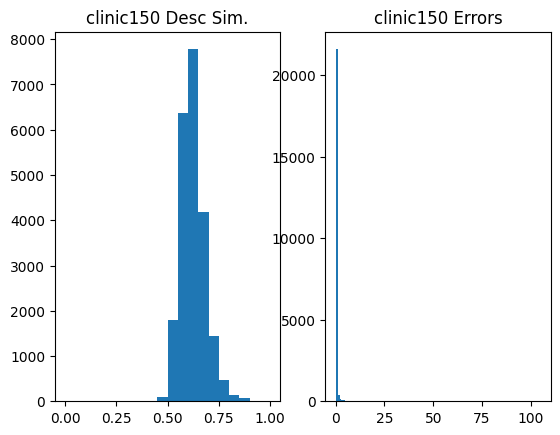

In [1362]:
figs, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(off_diag_sim, bins=torch.arange(0, 1.05, step=0.05))
axs[0].set_title(f"{task} Desc Sim.")

axs[1].hist(off_diag_cfm, bins=torch.arange(0, off_diag_cfm.max()))
axs[1].set_title(f"{task} Errors")

plt.show()

In [1363]:
np.unique(off_diag_cfm.flatten(), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,
         27,  29,  30,  35,  36,  38,  39,  44,  47,  51,  54,  56,  57,
         60,  61,  65,  66,  71,  74,  79,  87, 106]),
 array([21599,   358,   118,    49,    49,    30,    18,    13,    10,
           10,     7,     6,     5,     3,     3,     8,     3,     4,
            5,     3,     5,     4,     3,     1,     1,     4,     2,
            2,     4,     1,     3,     1,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     2,
            1,     1,     1]))

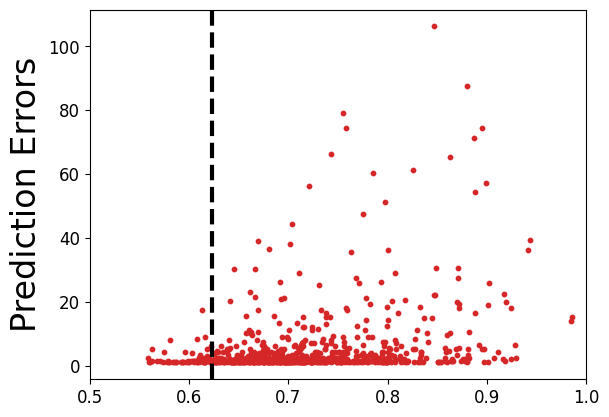

In [1364]:
from textwrap import wrap

torch.manual_seed(42)

xy_plot = []
for i in range(len(cfm)):
    for j in range(len(cfm)):
        if i != j and cfm[i, j] > 0:
            xy_plot.append((cfm[i, j] + (torch.rand(1) * 0.5).item(), desc_sims[i, j] + (torch.rand(1) * 0.01).item()))

[xs, ys] = list(zip(*xy_plot))
plt.scatter(ys, xs, s=10, c='tab:red')
plt.axvline(off_diag_sim.mean(), c='black', linestyle='--', linewidth=3)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0.5, 1.0])

# plt.xlabel("Intra-Description Similarity", fontdict={'fontsize': 24})
plt.ylabel('\n'.join(wrap("Prediction Errors", 25)), fontdict={'fontsize': 24})
plt.show()

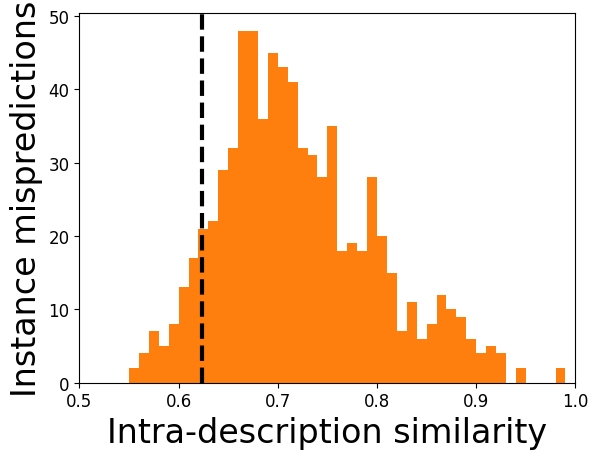

In [1369]:
ax = plt.gca()
plt.hist(ys, bins=torch.arange(round(off_diag_sim.min().item(), 1), 1.01, step=0.01), color='tab:orange')
plt.axvline(off_diag_sim.mean(), c='black', linestyle='--', linewidth=3)
plt.xlabel("Intra-description similarity", fontdict={'fontsize': 24})
plt.ylabel('\n'.join(wrap('Instance mispredictions', 25)), fontdict={'fontsize': 24})
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0.5, 1.0])
plt.show()

#### Compute skewness (Fisher-Pearson $g$)

In [1366]:
from scipy.stats import skew
fisher_pearson_g = skew(off_diag_sim)
print(f"Fisher-Pearson g={fisher_pearson_g:.3f}")

Fisher-Pearson g=0.798


#### Some light error attribution to see if this is caused by the candidate selector or the generator

In [1367]:
true_label_pos = torch.gather(intent_label_pos, dim=1, index=labels.unsqueeze(-1))
mispredict_label_pos = true_label_pos[(labels != preds)]

In [1368]:
print(f"Candidate Selector Error Rate: {(mispredict_label_pos >= 5).flatten().float().mean():.3f}")
print(f"Generator Error Rate: {(mispredict_label_pos < 5).flatten().float().mean():.3f}")


Candidate Selector Error Rate: 0.329
Generator Error Rate: 0.671
